In [68]:
#位相シフタとPDを想定した複素エンコーダのαを変える(0~1.0を拡大)

In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys

In [70]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoEncoder_data', 'MNIST_AE[6]αEX_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


1002
/Users/konishi/OneDrive/CODES/konishi_AutoEncoder/AutoEncoder_data/MNIST_AE[6]αEX_result


In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [72]:
import os
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0),(1)),lambda x: x.view(-1)])

root = os.path.join(onedrive_path,'CODES','samples','mnist_data')
mnist_train = datasets.MNIST(root=root,download=True,train=True,transform=transform)
mnist_test = datasets.MNIST(root=root,download=True,train=False,transform=transform)

train_dataloader = DataLoader(mnist_train,batch_size=100,shuffle=True)
test_dataloader = DataLoader(mnist_test,batch_size=100,shuffle=False)

In [73]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [74]:
#Encoder5
class Encoder(nn.Module):
    def __init__(self,in_features,out_features,alpha):
        super(Encoder, self).__init__()
        real_part = nn.Parameter(torch.randn(out_features, in_features)*(1/np.sqrt(in_features)))
        imag_part = nn.Parameter(torch.randn(out_features, in_features)*(1/np.sqrt(in_features)))
        self.B = torch.complex(real_part, imag_part).detach()
        self.B.requires_grad = False

        self.alpha = alpha
    
    def forward(self, x):
        x = torch.exp(1j * self.alpha * x) #e^(iαx)
        x = x.T
        x = torch.matmul(self.B, x)
        x = torch.abs(x) ** 2
        x = x.T
        return x

In [75]:
class Decoder(nn.Module):
    def __init__(self, num_in, num_out):
        super(Decoder, self).__init__()
        self.decoder_fc1 = nn.Linear(num_in,int((num_in+num_out)/2) )
        self.a1 = nn.Tanh()
        self.decoder_fc2 = nn.Linear(int((num_in+num_out)/2), num_out)
        self.a2 = nn.Sigmoid()

    def forward(self, x):
        x = self.decoder_fc1(x)
        x = self.a1(x)
        x = self.decoder_fc2(x)
        x = self.a2(x)
        return x

In [76]:
class AutoEncoder(nn.Module):
    def __init__(self,num_N,alpha):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(784, num_N,alpha)  
        self.decoder = Decoder(num_N, 784)  

    def forward(self, x):
        x = x.view(x.size(0), -1)
        
        z = self.encoder(x)
        
        x_reconstructed = self.decoder(z)
        return x_reconstructed

In [77]:
#MNISTのイメージを表示するやつ
def show_images(images, labels, title):
    images = images.view(images.size(0), 1, 28, 28)
    np.set_printoptions(precision=2)
    #print(images[1,0].double().numpy())
    images = images.detach().numpy()
    fig, axes = plt.subplots(1, 3, figsize=(10, 2))
    selected_digits = [5, 2, 4] ##
    selected_indices = [] 
    for digit in selected_digits:
        idx = (labels == digit).nonzero(as_tuple=True)[0]
        if len(idx) > 0:
            selected_indices.append(idx[0].item())
    for i, ax in enumerate(axes):
        if i < len(selected_indices):
            ax.imshow(images[selected_indices[i], 0], cmap='gray')
        ax.axis('off')
    plt.suptitle(title)

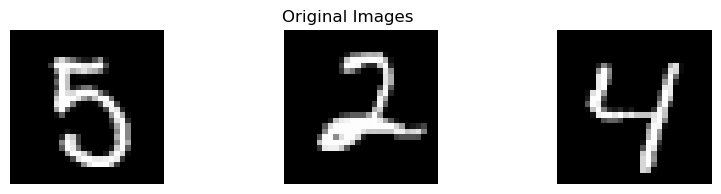

In [78]:
for i, (test_images, test_labels) in enumerate(test_dataloader):
    if i == 2:##
        break
show_images(test_images, test_labels,"Original Images")
file_name = 'originalMNISTimage(524).png'
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

Alpha:0.0025 Epoch: 9/10

loss_train: 0.0676,loss_test: 0.0679


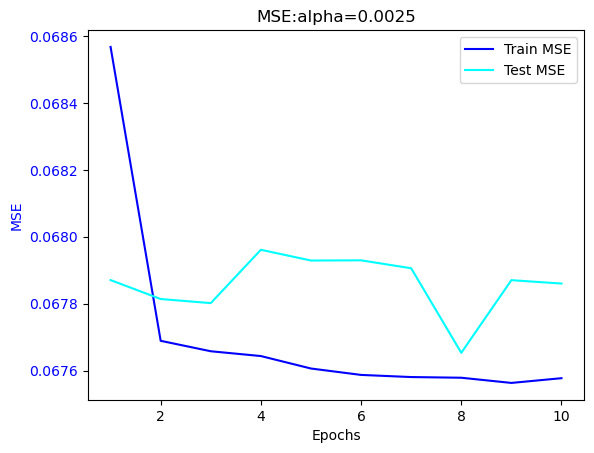

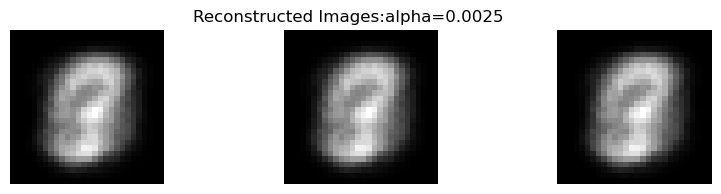

Alpha:0.1000 Epoch: 9/10

loss_train: 0.0164,loss_test: 0.0150


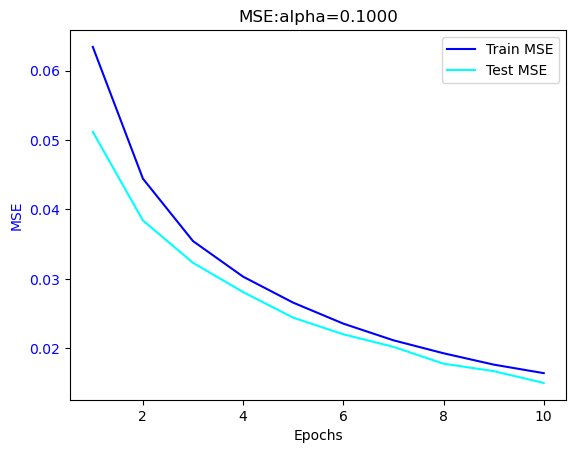

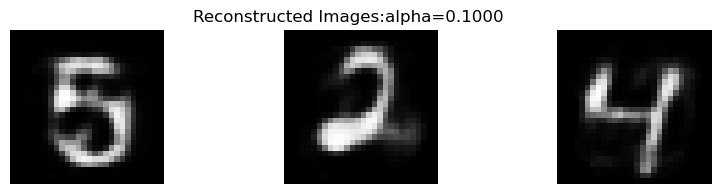

Alpha:0.2000 Epoch: 9/10

loss_train: 0.0107,loss_test: 0.0104


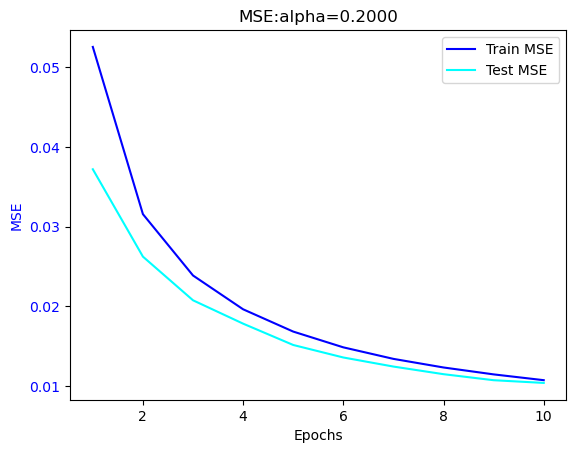

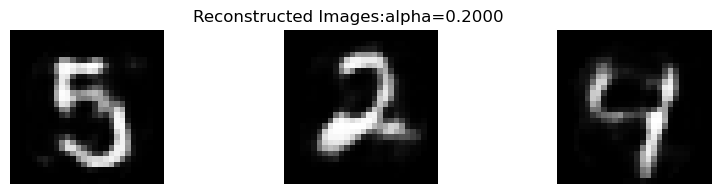

Alpha:0.4000 Epoch: 9/10

loss_train: 0.0071,loss_test: 0.0067


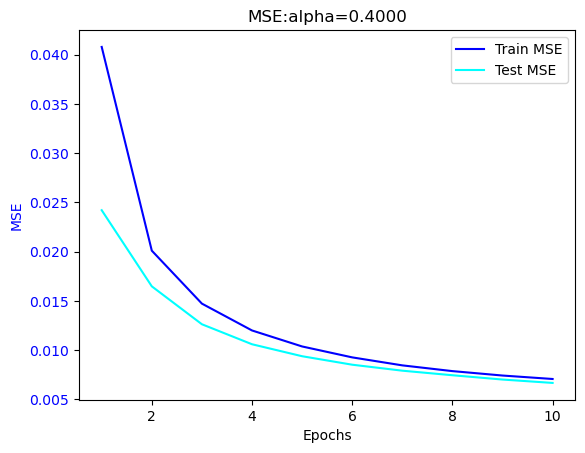

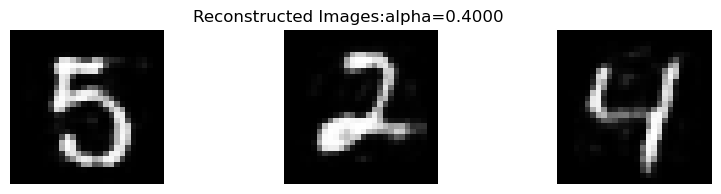

Alpha:0.8000 Epoch: 9/10

loss_train: 0.0065,loss_test: 0.0063


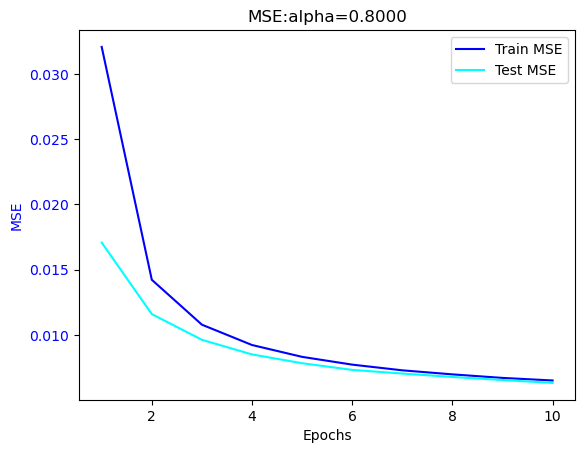

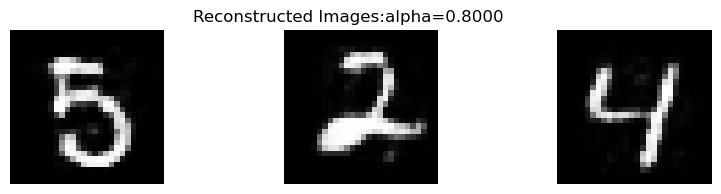

Alpha:1.0000 Epoch: 9/10

In [79]:
All_loss_train = []
All_loss_test = []

DofIN = 784
num_N = 128
DofOUT = 784

max_epochs = 10##
Rep = 400 #0.025~1.0
width = 0.0025 #Rep*width =end
num_measure = 10

start = width
end = 1.0

magic = int(Rep/num_measure)*num_measure*width

for i in range(1,Rep+1):

    alpha = i*width

    model = AutoEncoder(num_N,alpha).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    loss_train_ = []
    loss_test_ = []

    for epoch in range(max_epochs):
        loss_train = 0
        loss_test = 0
        sys.stderr.write('\rAlpha:%.4f Epoch: %d/%d' % (alpha, epoch, max_epochs)) 
        sys.stderr.flush()
        for (x,t) in train_dataloader:

            x, t = x.to(device), t.to(device)
            y = model(x)
            loss = criterion(y, x.view(x.size(0), -1)) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
       
        loss_train_avg = loss_train / len(train_dataloader)

        with torch.no_grad():
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x)
                loss = criterion(y, x.view(x.size(0), -1))
        
                loss_test += loss.item()

        loss_test_avg = loss_test / len(test_dataloader)

        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        
        if epoch == max_epochs-1:
            All_loss_train.append(loss_train_avg)
            All_loss_test.append(loss_test_avg)

    if alpha==0.0025 or alpha%(magic/num_measure)==0: ##    
        
        print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")

        fig, ax1 = plt.subplots()
        ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train MSE", color = 'blue')
        ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test MSE", color = 'cyan')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('MSE', color = 'blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.legend()

        title = 'MSE:alpha=%.4f'%(alpha) #
        plt.title(title)
        file_name = '%d_LOSS_alpha%.4f.png'%(int(formatted_date),alpha)
        full_path = os.path.join(save_directory, file_name)
        plt.savefig(full_path, dpi=100, bbox_inches='tight')
        plt.show()

        with torch.no_grad():
            test_images = test_images.to(device)
            reconstructed_images = model(test_images)
            image_title = 'Reconstructed Images:alpha=%.4f'%(alpha)
            show_images(reconstructed_images.cpu(),test_labels, image_title)
            file_name = '%d_ReImage_alpha%.4f.png'%(int(formatted_date),alpha)
            full_path = os.path.join(save_directory, file_name)
            plt.savefig(full_path, dpi=100, bbox_inches='tight')
            plt.show()


Train Min:α=0.7750,MSE=0.0065
Test Min :α=0.5725,MSE=0.0062


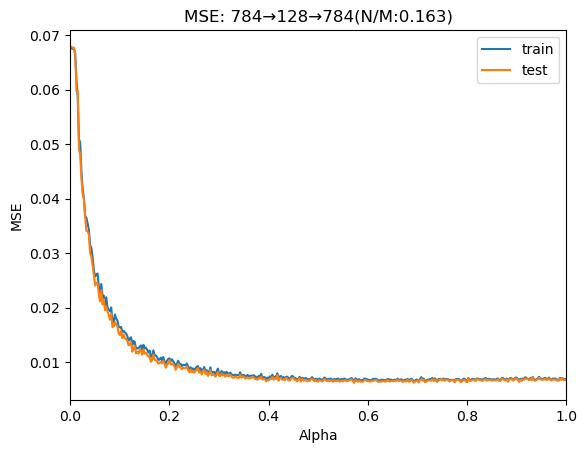

In [81]:
#print('shape',All_loss_train.shape)
min_MSE_train = np.min(All_loss_train)
min_MSE_test = np.min(All_loss_test)
min_index_train = All_loss_train.index(min_MSE_train)
min_index_test = All_loss_test.index(min_MSE_test)

print('Train Min:α=%.4f,MSE=%.4f'%((min_index_train+1)*width,min_MSE_train))
print('Test Min :α=%.4f,MSE=%.4f'%((min_index_test+1)*width,min_MSE_test))

x_values = np.linspace(start, Rep*width, Rep)
plt.plot(x_values, All_loss_train, label="train")
plt.plot(x_values, All_loss_test, label="test")
plt.xlabel('Alpha')
plt.ylabel('MSE')
title = 'MSE: %d→%d→%d(N/M:%.3f)'%(DofIN,num_N,DofIN,num_N/DofIN) ##
plt.title(title)
plt.legend()
plt.xlim(0,end)


file_name = '%d_AE[6]α_loss.png'%(int(formatted_date))##
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()

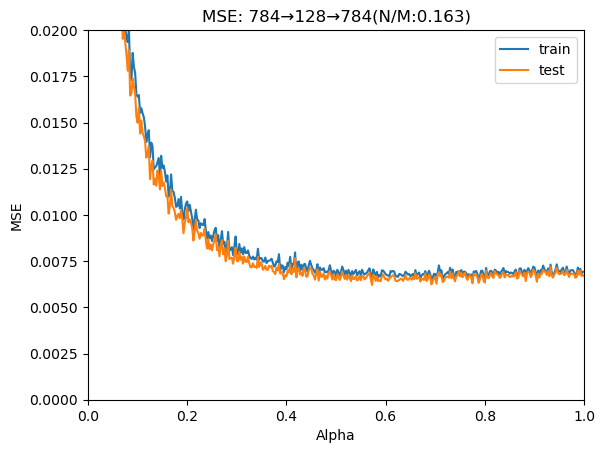

In [82]:
plt.plot(x_values, All_loss_train, label="train")
plt.plot(x_values, All_loss_test, label="test")
plt.xlabel('Alpha')
plt.ylabel('MSE')
title = 'MSE: %d→%d→%d(N/M:%.3f)'%(DofIN,num_N,DofIN,num_N/DofIN) ##
plt.title(title)
plt.legend()
plt.xlim(0,end)
plt.ylim(0,0.02)

file_name = '%d_AE[6]α_loss_Expand.png'%(int(formatted_date))##
full_path = os.path.join(save_directory, file_name)
plt.savefig(full_path, dpi=100, bbox_inches='tight')
plt.show()